# PSD Estimation for ORChiD

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from math import pi

from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from scipy.signal.windows import tukey

## Getting LIGO data

Let's get 4s of data around GW150914 to use in an inference analysis. (We will need to download more data to estimate the PSD, if one isn't already available.)

In [2]:
# first, fetch a 4s segment centered on GW150914
gps = event_gps("GW150914")
start = int(gps) - 2
end = int(gps) + 2

ifos = ['H1', 'L1']

data_td_dict = {ifo: TimeSeries.fetch_open_data(ifo, start, end) for ifo in ifos}

Let's look at the time-domain data for fun (since we are using GWpy, that package will format the plot nicely for us):

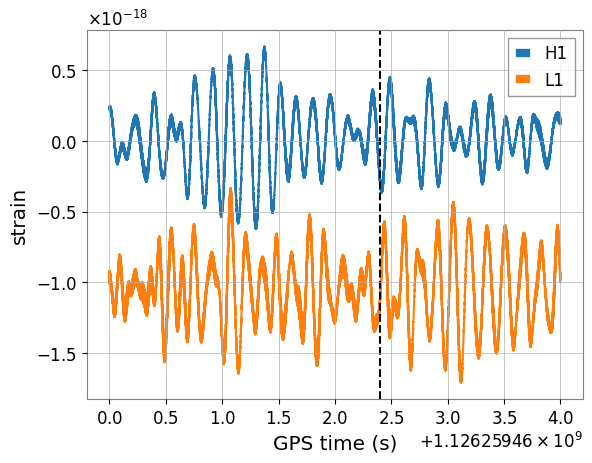

In [3]:
for ifo, data in data_td_dict.items():
    plt.plot(data, label=ifo)
plt.gca().axvline(gps, ls='--', c='k')
plt.xlabel('GPS time (s)')
plt.ylabel('strain')
plt.legend();

Let's Fourier transform the data, remembering first to window. We can do this using GWpy helper functions, or directly with numpy.

In [4]:
# GWpy normalizes the FFT like an instrumentalist would, which is not what we 
# want for the likelihoood, so fix this manually
n = len(data_td_dict[ifos[0]])
delta_t = data_td_dict[ifos[0]].dt.value

data_fd_dict = {i: (d*tukey(n, 0.2)).fft()*n*delta_t/2 
                for i,d in data_td_dict.items()}

print(data_fd_dict[ifos[0]].frequencies.value)
raise

# do the same but with numpy to illustrate what's going on, with the 
# normalization we want for the likelihood
data_fd_np_dict = {i: np.fft.rfft(d*tukey(n, 0.2))*delta_t 
                   for i,d in data_td_dict.items()}
freq = np.fft.rfftfreq(n, delta_t)

[0.00000e+00 2.50000e-01 5.00000e-01 ... 2.04750e+03 2.04775e+03
 2.04800e+03]


RuntimeError: No active exception to reraise

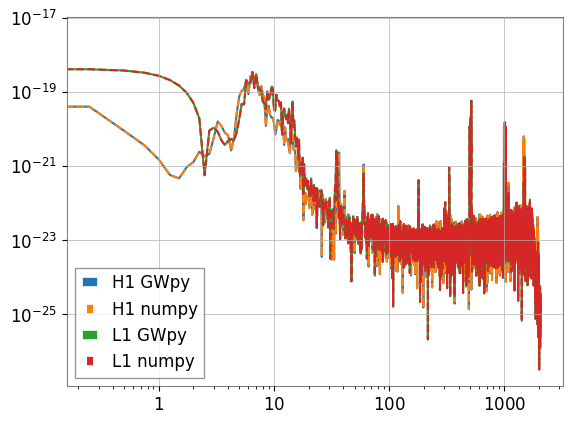

In [8]:
for ifo in ifos:
    # plot GWpy result
    plt.loglog(np.abs(data_fd_dict[ifo]), label=f"{ifo} GWpy")
    # plot numpy result
    plt.loglog(freq, np.abs(data_fd_np_dict[ifo]), label=f"{ifo} numpy", ls='--')
plt.legend();

If confused about FFT normalizations, see, e.g., the way Bilby does it [here](https://github.com/lscsoft/bilby/blob/b1e02f1dfae03d4939cae9c95eff300c22919689/bilby/core/utils/series.py#L198) vs how GWPy does it [here](https://github.com/gwpy/gwpy/blob/v2.1.4/gwpy/timeseries/timeseries.py#L130-L169); also check out a classic reference for these operations [Allen et al (2012)](https://arxiv.org/abs/gr-qc/0509116).

From the plot, notice the sharp turnover at high frequencies, which is due to the antialiasing filter that GWOSC applies; this shouldn't be a problem for us as long as we truncate the likelihood integration well before that.

### Power spectrum

Let's get some more data to estimate the PSD (or we could download a pre-made PSD from somewhere).

In [9]:
start = int(gps) - 16
end = int(gps) + 16

psd_data_td_dict = {ifo: TimeSeries.fetch_open_data(ifo, start, end) for ifo in ifos}

Compute PSD with GWpy utilities first.

In [10]:
psd_dict = {i: d.psd(fftlength=4) for i,d in psd_data_td_dict.items()}

For the first IFO, check that GWpy gave the same thing we get by calling Welch directly.

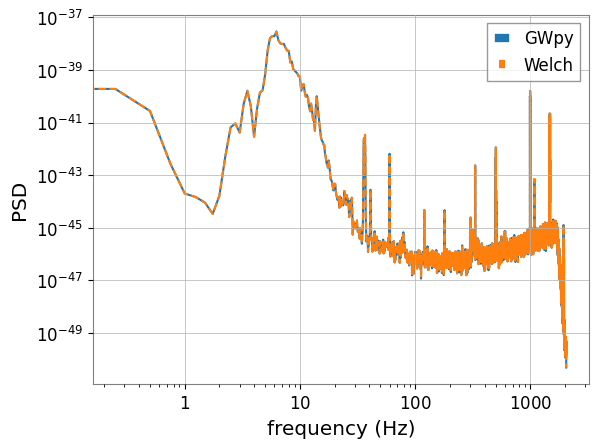

In [11]:
import scipy.signal as ss
ifo = 'H1'

d = psd_data_td_dict[ifo]
fs = d.sample_rate.value
freq_psd, p_welch = ss.welch(d, fs=fs, nperseg=4*fs, average='median')

plt.loglog(psd_dict[ifo], label='GWpy')
plt.loglog(freq_psd, p_welch, ls='--', label='Welch')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend();

With the PSDs, we may whiten the data.

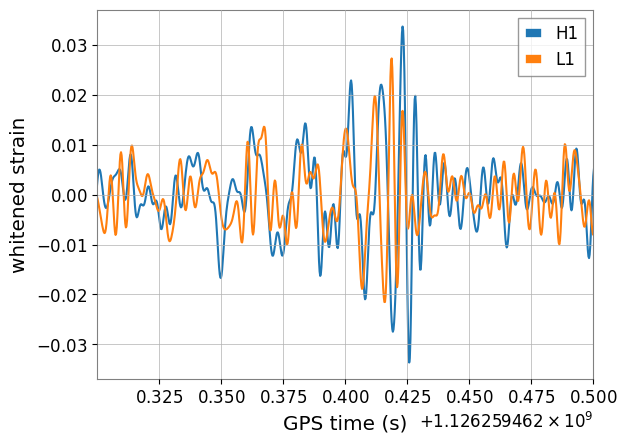

In [12]:
for i, d_fd in data_fd_dict.items():
    # whiten (missing prop constants)
    wd_fd = d_fd / np.sqrt(psd_dict[i])
    # do some brute-force bandpassing
    wd_fd[np.array(wd_fd.frequencies.data) < 30.] = 0
    wd_fd[np.array(wd_fd.frequencies.data) > 300.] = 0
    # go back to time domain and plot
    wd_td = np.fft.irfft(wd_fd.data)
    plt.plot(data_td_dict[i].times, wd_td, label=i)
plt.xlim(gps-0.1, gps+0.1)
plt.xlabel('GPS time (s)')
plt.ylabel('whitened strain')
plt.legend();